In [4]:
from tensorflow import keras, data
from keras import layers
import numpy as np
from keras import backend as K
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import scipy.io
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

class VAE(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.fc1 = layers.Dense(hidden_dim, activation='relu')
        self.fc21 = layers.Dense(latent_dim)  # Mean
        self.fc22 = layers.Dense(latent_dim)  # Log variance

        # Decoder
        self.fc3 = layers.Dense(hidden_dim, activation='relu')
        self.fc4 = layers.Dense(input_dim, activation='sigmoid')

    def encode(self, x):
        h1 = self.fc1(x)
        mu = self.fc21(h1)
        logvar = self.fc22(h1)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        eps = tf.random.normal(shape=tf.shape(mu))
        std = tf.exp(0.5 * logvar)
        return mu + eps * std

    def decode(self, z):
        h3 = self.fc3(z)
        return self.fc4(h3)

    def call(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        self.add_loss(self.vae_loss(x, reconstructed, mu, logvar))  # Adding loss inside the model
        return reconstructed

    def vae_loss(self, x, recon_x, mu, logvar):
        bce = tf.keras.losses.binary_crossentropy(x, recon_x)
        bce = tf.reduce_sum(bce, axis=-1)
        kld = -0.5 * tf.reduce_sum(1 + logvar - tf.square(mu) - tf.exp(logvar), axis=-1)
        return tf.reduce_mean(bce + kld)

#x_train = scipy.io.loadmat(f'input_data_models_1_F_10000.mat')['train_input_data']

# Load Data

x_train = scipy.io.loadmat(f'input_data_models_1_dlp_50_F_10000.mat')['Final_input_data']
# Load model and best feature
best_feature_models_1_F_10000 = pd.read_csv("best_solution_models_1_F_10000.csv")
model_1 = pickle.load(open('models_1_F_10000.pkl', "rb"))
feature_indices = best_feature_models_1_F_10000.iloc[9:-2, 1].astype(int).values

filtered_test_data = x_train[:, feature_indices]
train_predictions = model_1.predict(filtered_test_data)

input_dim = np.shape(x_train)[1] #原始資料的特徵數量

x_train_min = np.min(x_train)
x_train_max = np.max(x_train)

x_train = (x_train - x_train_min) / (x_train_max - x_train_min)



batch_size = 496        #每次訓練時處理的數據樣本數量。
hidden_dim = 200        #隱藏層大小
latent_dim = 36          #編碼大小
sample_number = 500     #生成樣本數
train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(len(x_train)).batch(batch_size)

# Initialize VAE and Train
vae = VAE(input_dim, hidden_dim, latent_dim)
vae.compile(optimizer=tf.keras.optimizers.AdamW())
vae.fit(train_dataset, epochs=1000)



mu, logvar=vae.encode(x_train)

global_mu=np.mean(mu.numpy(), axis=0)
global_lovar=np.sqrt(np.mean(np.exp(logvar.numpy()),axis=0))

Epoch 1/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 777ms/step - loss: 347.1433
Epoch 2/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 336.0370
Epoch 3/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 325.3235
Epoch 4/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 315.1277
Epoch 5/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 304.0023
Epoch 6/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 294.0749
Epoch 7/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 282.8221
Epoch 8/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 272.6173
Epoch 9/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 261.0443
Epoch 10/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 249.1355
Epoch 11/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 237.6394
Epoch 12/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 225.2605
Epoch 13/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 213.9657
Epoch 14/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 201.3632
Epoch 15/1000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [5]:
# Generate new data
latent_samples=np.random.normal(global_mu,global_lovar,size=(sample_number,latent_dim)).astype(np.float32)



generated_data = vae.decode(latent_samples)



Generated data shape: (500, 901)


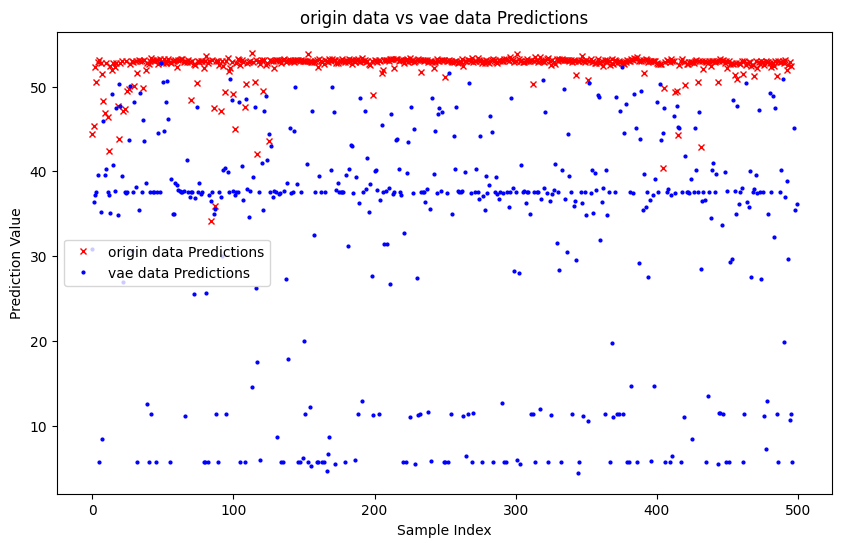

In [6]:
generated_data = (generated_data * (x_train_max - x_train_min)) + x_train_min


print("Generated data shape:", generated_data.shape)




# 確保 feature_indices 不超過 generated_data 的範圍
max_feature_index = generated_data.shape[1] - 1
feature_indices = feature_indices[feature_indices <= max_feature_index]

# 轉換為 NumPy 數組
feature_indices = np.array(feature_indices, dtype=np.int32)

# 確保 generated_data 是 NumPy 陣列
if isinstance(generated_data, tf.Tensor):
    generated_data = generated_data.numpy()

# 確保 feature_indices 是 list
feature_indices = feature_indices.tolist()

# 進行索引

generated_test_data = generated_data[:, feature_indices]


test_predictions = model_1.predict(generated_test_data)

# 畫圖
plt.figure(figsize=(10, 6))
plt.plot(train_predictions,'rx', label="origin data Predictions",markersize=5)
plt.plot(test_predictions,'bo', label="vae data Predictions",markersize=2)

# 圖例與標題
plt.xlabel("Sample Index")
plt.ylabel("Prediction Value")
plt.title("origin data vs vae data Predictions")
plt.legend()
plt.show()